# Overview
This is a implementation of a simple linear neural network that reads in text and uses pretrained embeddings to predict the **happiness intensity** of the text.
It fit the network weights using the analytic expression we discussed in class.

For this implementation I will use the functionality of PyTorch, HuggingFace "transformers" library for getting pretrained models, "pandas" for data loading, matplotlib for visualization.

In [1]:
import torch
from transformers import AutoModel, AutoTokenizer
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## **Getting and processing data**

In [2]:
# Load dataset and visualize
train_file = 'EI-reg-En-joy-train.txt'
val_file = '2018-EI-reg-En-joy-dev.txt'
df_train = pd.read_csv(train_file, sep='\t')
df_val = pd.read_csv(val_file, sep='\t')

tweets_train = df_train['Tweet'].tolist()  # Create a list of tweets
tweets_val = df_val['Tweet'].tolist()

# Create a list of intensity scores
y_train = torch.tensor(df_train['Intensity Score'], dtype=torch.float32)  # match to dtype of embedding
y_val = torch.tensor(df_val['Intensity Score'], dtype=torch.float32)

print('Score - Tweet')
for i in range(5):
    print('{:0.2f} - {}'.format(y_train[i], tweets_train[i]))

Score - Tweet
0.14 - @david_garrett Quite saddened.....no US dates, no joyous anticipation of attending a DG concert (since 2014). Happy you are keeping busy.
0.79 - 2 days until #GoPackGo and 23 days until #GoGipeGo..... I'm so excited! 
0.27 - Positive #psychology research shows salespeople who score in the top 10% for #optimism have 88% &gt; sales than those in top 10% for pessimism.
0.48 - As the birds chirp and the cows moo we need to listen to the sound of nature to ensure that all is well.
0.94 - Howling with laughter at “WELL DONE BEZZA!” #bakeoff #GBBO


In [3]:
# Load a pretrained model and write a function that embeds sentences into vector space
# Use the approach shown in Jan. 19 class (or improve on it)

model_name="bert-base-uncased"  # Many possibilities on huggingface.com

# load the pretrained model
embed_model = AutoModel.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

def embed_sentence(model, tokenizer, sentence):
    """Function to embed a sentence as a vector using a pre-trained model."""
    inputs = tokenizer(sentence, return_tensors="pt")

    with torch.no_grad():
      outputs = model(**inputs)

    return outputs.last_hidden_state[0].mean(dim=0)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

In [ ]:
# Use embed_sentence to turn text into a matrix of embeddings.
# Create a pytorch matrix where each row corresponds to a tweet,
# and the number of columns/features is the size of the embedding
# (Obviously one for train and one for validation)
# For me, on the CPU of my laptop, it took few minutes to do the processing

# X_train = torch.randn((len(y_train), 768))  # Delete and replace placeholder
# X_val = torch.randn((len(y_val), 768))  # Delete and replace placeholder

X_train_list = []
for t in tweets_train:
  e = embed_sentence(embed_model, tokenizer, t)
  X_train_list.append(e)
X_train = torch.stack(X_train_list)

X_val_list = []
for t in tweets_val:
  e = embed_sentence(embed_model, tokenizer, t)
  X_val_list.append(e)
X_val = torch.stack(X_val_list)

print(X_train.shape, X_val.shape)

torch.Size([1616, 768]) torch.Size([290, 768])


## Define the model [5 points]

In [5]:
class MyLinearNet(torch.nn.Module):
    def __init__(self, embedding_size):
        super().__init__()  # init superclass - enables many pytorch model capabilities
        self.d = embedding_size  # Often convenient to store this (not a "Parameter" though as we don't train it)
        # TODO [1 point]: define weights and bias parameters
        self.w = torch.nn.Parameter(torch.zeros(self.d))
        self.b = torch.nn.Parameter(torch.zeros(1))

    def forward(self, x):
        """Implement a linear model"""
        # Implement linear model, in terms of weights and biases
        # It should work on a single x, or a batch
        # y_hat = torch.ones(len(x))  # This gives a constant prediction - delete when you implement your method
        y_hat = torch.matmul(x, self.w) + self.b
        return y_hat

    def fit(self, X, y):
        """Given a data matrix, X, and a vector of labels for each row, y,
        analytically fit the parameters of the linear model."""
        # Use linear regression formula to set weight and bias parameters

        # (a) First, construct the augmented data matrix as discussed in class
        one = torch.ones(len(X), 1)
        augmented = torch.cat([X, one], dim=1)

        # (b) Next, use matrix multiplication and torch.linalg.inv to implement the analytic solution
        # w = torch.randn(self.d + 1)  # delete and replace
        # w = torch.linalg.inv(augmented.T)
        w = torch.linalg.pinv(augmented)
        w = torch.matmul(w, y)

        # (c) Put the solution (which includes weights and biases) into parameter
        # Use "data" to update parameters without affecting computation graph
        # (Kind of a subtle point - no need to modify my code below)
        self.w.data = w[:self.d]
        self.b.data = w[-1]


## Results [8 points]

In [6]:
def loss(model, X, y):
    # Implement the mean square error loss
    y_pred = model(X)
    MSE = torch.nn.MSELoss()
    return MSE(y_pred, y)


d = X_train.shape[1]  # embedding dimension
model = MyLinearNet(d)

loss_train = loss(model, X_train, y_train)
loss_val = loss(model, X_val, y_val)
print("\nLoss on train and validation BEFORE fitting.\nTrain: {:0.3f}, Val: {:0.3f}".format(loss_train, loss_val))

model.fit(X_train, y_train)

loss_train = loss(model, X_train, y_train)
loss_val = loss(model, X_val, y_val)

# Show that Train loss is reduced below 0.02
# and Validation loss is reduced below 0.05, at least

print("\nLoss on train and validation AFTER fitting.\nTrain: {:0.3f}, Val: {:0.3f}".format(loss_train, loss_val))



Loss on train and validation BEFORE fitting.
Train: 0.294, Val: 0.290

Loss on train and validation AFTER fitting.
Train: 0.009, Val: 0.044


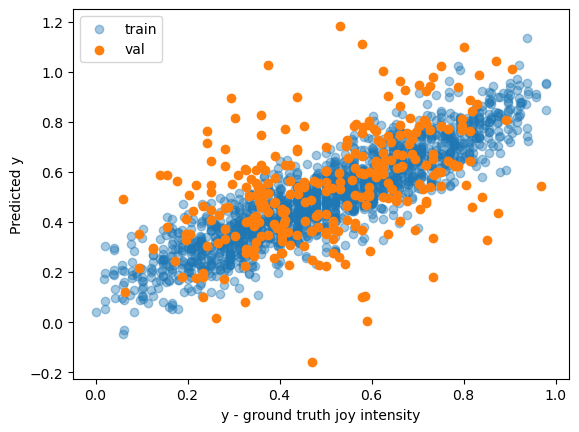

In [7]:
# Create a scatter plot of the actual vs. predicted values of `y` using this function.
def plot(y_train, y_hat_train, y_val, y_hat_val):
    fig, ax = plt.subplots(1)
    ax.scatter(y_train, y_hat_train, alpha=0.4, label='train')
    ax.scatter(y_val, y_hat_val, label='val')
    ax.set_xlabel('y - ground truth joy intensity')
    ax.set_ylabel('Predicted y')
    ax.legend()


# Show y_hat versus y on train and val data
# Should be no need to modify code, you get 1 point for getting
# something that looks correct.
with torch.no_grad():  # remember to turn off auto gradient tracking
    y_hat_train = model(X_train)
    y_hat_val = model(X_val)

plot(y_train, y_hat_train, y_val, y_hat_val)

In [8]:
# Put in a sample sentence of your own construction and output the "joy meter" for a happy and sad sentence
happy = "I'm so happy that my car is fixed and ready to pickup"
sad = "I am so tired of tasks in the to-do list"

# model1 = AutoModel.from_pretrained(model_name)
embedded_happy = embed_sentence(embed_model, tokenizer, happy)
embedded_sad = embed_sentence(embed_model, tokenizer, sad)

with torch.no_grad():
    y_hat_happy = model(embedded_happy)
    y_hat_sad = model(embedded_sad)

# y_hat_happy = 0.8  # Delete and replace
# y_hat_sad = 0.05  # Delete and replace

print('{:0.2f} - {}'.format(y_hat_happy, happy))
print('{:0.2f} - {}'.format(y_hat_sad, sad))

0.47 - I'm so happy that my car is fixed and ready to pickup
0.17 - I am so tired of tasks in the to-do list
